# Classification
1. [Simple Logistic Regression](#1.-Simple-Logistic-Regression)
1. [Multiple Logistic Regression](#2.-Multiple-Logistic-Regression)
1. [Softmax Classification](#3.-Softmax-Classification)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Simple Logistic Regression

Model for Simple logistic regression: $p = \frac{\mathrm{e}^y}{1+\mathrm{e}^y}$

where

$y = \beta_0 + \beta x$


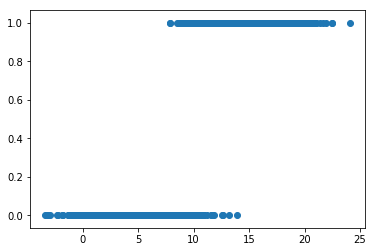

In [2]:
# simulate binary data
x0 = np.random.normal(5, 2.5, 1000)
x1 = np.random.normal(15, 2.5, 1000)

x = np.append(x0, x1)
y = np.asarray([0.0] * len(x0) + [1.0] * len(x1))

plt.scatter(x, y)
plt.show()

After several tries the cost function that did well was:

$-\sum_{i=1}^{n} [y_i\log(p(x_i)) + (1-y_i) \log(1-p(x_i))]$

* log terms are necessary else optimiser does not update significantly or gets stuck in some local minima.
* Tried to use reduce_prod() instead of reduce_mean(). Optimiser could not calculate cost and update weights. Cost were set to 0 for all epochs.

In [15]:
X = tf.placeholder(dtype=tf.float32)
Y = tf.placeholder(dtype=tf.float32)

# weights (b0 and b1)
w = tf.Variable([np.random.randn(), np.random.randn()], dtype=tf.float32)

y_linear = tf.add(w[0], tf.multiply(w[1], X))
model = tf.sigmoid(y_linear)

# if prob > 0.5 set y=1 else set y=0
activation = tf.to_float(tf.greater(model, 0.5))

# has to include log terms
cost = tf.negative(tf.reduce_mean(tf.add(Y * tf.log(model), (1-Y)*tf.log(1-model))))

accuracy = tf.reduce_mean(tf.to_float(tf.equal(Y, activation)))

epochs=500

train_op = tf.train.GradientDescentOptimizer(0.05).minimize(cost)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        sess.run(train_op, feed_dict={X: x, Y: y})
    
    weights = sess.run(w)
    c = sess.run(cost, feed_dict={X: x, Y: y})
    acc = sess.run(accuracy, feed_dict={X: x, Y: y})
    print('i={}: w={}, accuracy={}, cost={}'.format(i, weights, acc, c))
    
    all_x = np.linspace(min(x), max(x), len(x))
    y_fitted = sess.run(model, feed_dict={X: all_x})

i=499: w=[-2.532096    0.30488172], accuracy=0.949999988079071, cost=0.25665712356567383


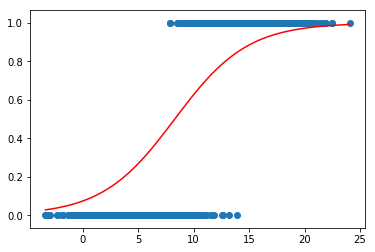

In [16]:
# plot fitted model
plt.scatter(x, y)
plt.plot(all_x, y_fitted, 'r')
plt.show()

## 2. Multiple Logistic Regression

Model for Multiple logistic regression: $p = \frac{\mathrm{e}^y}{1+\mathrm{e}^y}$

where

$y = \beta_0 + \beta_1 x_1 + ...... + \beta_n x_n$


In [11]:
# read dataset from csv-easy way
# columns ['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased']
import pandas as pd
df = pd.read_csv('Datasets/Social_Network_Ads.csv')
print(df.head())
# set 'User ID' column to 1
# User Ids are not needed for our model
# setting them 1 simplifies linear model to bel built
df['User ID'] = 1

xo = df.loc[:,['User ID', 'Gender', 'Age', 'EstimatedSalary']]
x = xo.copy()
y = df.loc[:,'Purchased']

# preprocessing
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
x.loc[:,['Age', 'EstimatedSalary']] = scalar.fit_transform(x.loc[:,['Age', 'EstimatedSalary']])

# label encoding
x.loc[:, 'Gender'] = [float(v == 'Male') for v in x.loc[:, 'Gender']]
xo.loc[:, 'Gender'] = x.loc[:, 'Gender']

xo = xo.transpose()
x = x.transpose()

print('Preprocessed data')
print(x.iloc[:, :5])
print(xo.iloc[:, :5])

    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0
Preprocessed data
                        0         1         2         3         4
User ID          1.000000  1.000000  1.000000  1.000000  1.000000
Gender           1.000000  1.000000  0.000000  0.000000  1.000000
Age             -1.781797 -0.253587 -1.113206 -1.017692 -1.781797
EstimatedSalary -1.490046 -1.460681 -0.785290 -0.374182  0.183751
                       0        1        2        3        4
User ID              1.0      1.0      1.0      1.0      1.0
Gender               1.0      1.0      0.0      0.0      1.0
Age                 19.0     35.0     26.0     27.0     19.0
EstimatedSalary  19000.0  20000.0  43000.0  57000.0  76000.0


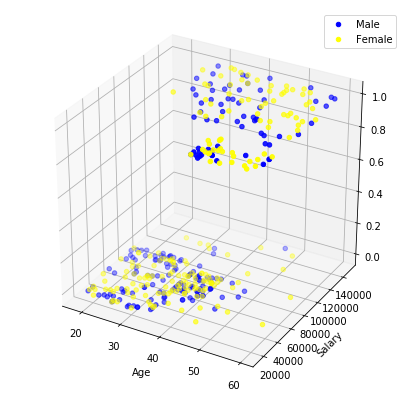

In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

male = xo.loc[:, xo.loc['Gender']==1.0]
female = xo.loc[:, xo.loc['Gender']==0.0]
ym = y.loc[xo.loc['Gender']==1.0]
yf = y.loc[xo.loc['Gender']==0.0]

ax.scatter(male.loc['Age',:], male.loc['EstimatedSalary',:], ym, c='blue', label='Male')
ax.scatter(female.loc['Age',:], female.loc['EstimatedSalary',:], yf, c='yellow', label='Female')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.legend()
plt.show()

In [13]:
def linear_model(X, num_var):
    value = abs(np.random.randn())
    w = tf.Variable([value] * num_var, dtype=tf.float32, name='weights')
    terms = []
    for i in range(num_var):
        term = tf.multiply(w[i], X[i])
        terms.append(term)
    
    model = tf.add_n(terms)
    return model, w

In [20]:
epochs=100
learning_rate=0.1

# drop gender
x = x.drop(index='Gender', errors='ignore')
num_vars = x.shape[0]

Cost function: $-\sum_{i=1}^{n} [y_i\log(p(x_i)) + (1-y_i) \log(1-p(x_i))]$

In [21]:
X = tf.placeholder(dtype=tf.float32, name='X_ph')
Y = tf.placeholder(dtype=tf.float32, name='Y_ph')

y_linear, w = linear_model(X, num_vars)
model = tf.sigmoid(y_linear)

# if probability > 0.5 set y = 1 else set y = 0
activation = tf.to_float(tf.greater(model, 0.5))

# cost function
cost = tf.negative(tf.reduce_mean(Y * tf.log(model) + (1-Y)*(tf.log(1-model))))

# accuracy correctly classified observations
accuracy = tf.reduce_mean(tf.to_float(tf.equal(Y, activation)))

# training operation
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# using debugger as well this time
sess = tf.InteractiveSession()

# from tensorflow.python import debug as tf_debug
# sess = tf_debug.LocalCLIDebugWrapperSession(sess)
# sess.add_tensor_filter('inf_nan_filter', tf_debug.has_inf_or_nan)

tf.global_variables_initializer().run()
for i in range(epochs):
    sess.run(train_op, feed_dict={X: x, Y: y})
    
    weights = sess.run(w)
    c = sess.run(cost, feed_dict={X: x, Y: y})
    acc = sess.run(accuracy, feed_dict={X: x, Y: y})
    print('i={}: w={}, accuracy={}, cost={}'.format(i, weights, acc, c))

y_fitted = sess.run(activation, feed_dict={X: x})

sess.close()

i=0: w=[0.41667068 0.4593968  0.4472033 ], accuracy=0.6100000143051147, cost=0.6130383014678955
i=1: w=[0.39326203 0.47770002 0.45354435], accuracy=0.6200000047683716, cost=0.6039172410964966
i=2: w=[0.3704176  0.49558365 0.4596924 ], accuracy=0.6324999928474426, cost=0.5952270030975342
i=3: w=[0.3481216  0.513062   0.46565688], accuracy=0.6549999713897705, cost=0.5869441628456116
i=4: w=[0.3263586 0.5301489 0.4714468], accuracy=0.6675000190734863, cost=0.5790465474128723
i=5: w=[0.30511326 0.546858   0.47707084], accuracy=0.6825000047683716, cost=0.5715130567550659
i=6: w=[0.28437066 0.56320244 0.48253715], accuracy=0.7049999833106995, cost=0.5643239617347717
i=7: w=[0.2641162  0.57919496 0.48785356], accuracy=0.7250000238418579, cost=0.5574603080749512
i=8: w=[0.24433558 0.5948479  0.49302748], accuracy=0.737500011920929, cost=0.5509045124053955
i=9: w=[0.22501488 0.6101732  0.49806595], accuracy=0.737500011920929, cost=0.5446397662162781
i=10: w=[0.20614058 0.62518245 0.50297564], a

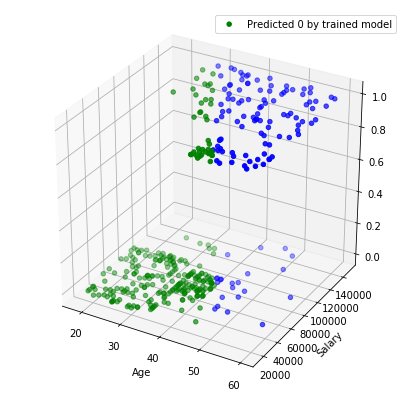

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
age = xo.loc['Age',:]
salary = xo.loc['EstimatedSalary', :]
gender = xo.loc['Gender', :]
cmap = {1.0: 'blue', 0.0: 'green'}
color = [cmap[t] for t in y_fitted]

array = np.asmatrix(y_fitted)

ax.scatter(age, salary, y, c=color)
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
# ax.plot_surface(all_age, all_salary, array)
plt.legend(['Predicted 0 by trained model'])
plt.show()

## 3. Softmax Classification

Softmax function is an extension of logistic function, that can be used for classification involving more than two classes. It returns probabilties for K classes for each data point and classifies data into one with highest probability. Sum of probabilities over k classes equals 1.

Softmax Function: $P(y=j|x) = \frac{\mathrm{e^{y_j}}}{\sum_{k=1}^{K}\mathrm{e^{y_k}}}$

where $y_j = \textbf{x}^{T}\textbf{w}_j$

$\textbf{w}_j=$ weight vector for $j^{th}$ class

and $\textbf{x}^T=$ Input matrix

In [8]:
# a method to split dataset into train and test with given ratio
def split_test_train(x, y, ratio = 0.8):
    num = int(x.shape[0] * ratio)
    x_train = x[0:num, :]
    y_train = y[0:num, :]
    x_test = x[num:x.shape[0], :]
    y_test = y[num:x.shape[0], :]
    return x_train, y_train, x_test, y_test

In [9]:
# import dataset
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
import pandas as pd
df = pd.read_csv('Datasets/iris.csv', header=None, names=columns)
print(df.head())

x = df.iloc[:, :-1]
x.insert(loc=0, column='ones', value = [1.0] * x.shape[0])
y = df.iloc[:, -1]

# preprocessing-label encode 'type' in a one-vs-all fashion
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y = encoder.fit_transform(y)

shuffle = tf.random_shuffle(np.hstack((x, y)))

with tf.Session() as sess:
    data = sess.run(shuffle)

print(data)
x = data[:, :-3]
y = data[:, -3:]

   sepal_length  sepal_width  petal_length  petal_width         type
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa
[[1.  4.4 3.2 ... 1.  0.  0. ]
 [1.  5.2 4.1 ... 1.  0.  0. ]
 [1.  6.3 2.7 ... 0.  0.  1. ]
 ...
 [1.  4.9 3.  ... 1.  0.  0. ]
 [1.  6.8 3.2 ... 0.  0.  1. ]
 [1.  5.6 3.  ... 0.  1.  0. ]]


In [10]:
num_vars = x.shape[1]
num_classes = y.shape[1]
learning_rate = 0.1
epochs = 500

In [18]:
x_train, y_train, x_test, y_test = split_test_train(x, y, 0.6)

X = tf.placeholder(dtype=tf.float32, shape=[None, num_vars])
Y = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

# define softmax model
w = tf.Variable(tf.random_normal(shape=[num_vars, num_classes]), dtype=tf.float32)

model = tf.nn.softmax(tf.matmul(X, w))

activation = tf.argmax(model, axis=1)

cost = tf.negative(tf.reduce_mean(Y * tf.log(model)))

accuracy = tf.reduce_mean(tf.to_float(tf.equal(activation, tf.argmax(Y,axis=1))))

train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

sess = tf.InteractiveSession()

tf.global_variables_initializer().run()

for i in range(epochs):
    sess.run(train_op, feed_dict={X: x_train, Y: y_train})
    
    if (i+1) % 50 == 0:
        weights = sess.run(w)
#         c = sess.run(cost, feed_dict={X: x, Y: y})
        trainacc = sess.run(accuracy, feed_dict={X: x_train, Y: y_train})
        testacc = sess.run(accuracy, feed_dict={X: x_test, Y: y_test})
        print('epoch={}: train accuracy={}, test accuracy={}'.format(i+1, trainacc, testacc))

sess.close()

epoch=50: train accuracy=0.5777778029441833, test accuracy=0.5166666507720947
epoch=100: train accuracy=0.6222222447395325, test accuracy=0.6333333253860474
epoch=150: train accuracy=0.699999988079071, test accuracy=0.6833333373069763
epoch=200: train accuracy=0.7666666507720947, test accuracy=0.75
epoch=250: train accuracy=0.8111110925674438, test accuracy=0.8166666626930237
epoch=300: train accuracy=0.8444444537162781, test accuracy=0.8500000238418579
epoch=350: train accuracy=0.8666666746139526, test accuracy=0.8833333253860474
epoch=400: train accuracy=0.9444444179534912, test accuracy=0.9166666865348816
epoch=450: train accuracy=0.9555555582046509, test accuracy=0.9166666865348816
epoch=500: train accuracy=0.9555555582046509, test accuracy=0.9333333373069763
